In [12]:
%load_ext autoreload
%autoreload 2

import torch

#from lib.model.progen.init_model import init_model
from lib.model.extended.init_model import init_model
from lib.model.train import train
from lib.model.progen.init_tokenizer import init_tokenizer
from lib.data.datasets.GB1 import get_GB1_dataset

Device

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Tokenizer

In [14]:
tokenizer = init_tokenizer()
tokenize = lambda sequence: torch.tensor(tokenizer.encode(sequence).ids)

Model

In [15]:
#model = init_model().to(device)
model = init_model(state_dict_path="/models/progen_extended_data_balanced_01.pt").to(device)

Some weights of the model checkpoint at s:\Documents\master\code\llm\lib\model\progen/../../../../../ProGen/progen/progen2/checkpoints/progen2-small were not used when initializing ProGenModel: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing ProGenModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ProGenModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


loading model state dict from file "s:\Documents\master\code\llm/models/progen_extended_data_balanced_01.pt"


In [ ]:
print([param for param in model.parameters()])

In [17]:
max(abs(model.fitness_head.weight[0]))

tensor(0.0345, device='cuda:0', grad_fn=<UnbindBackward>)

In [ ]:
model

Trained model sandbox

In [ ]:

from lib.model.extended.init_model import init_model
from lib.model.progen.init_tokenizer import init_tokenizer
from lib.data.datasets.GB1 import prepare_sequences, tokenize_batch, load_data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = init_tokenizer()
tokenize = lambda sequence: torch.tensor(tokenizer.encode(sequence).ids)

info = loss_history = torch.load("./models/progen_extended_data_balanced_01_info.pt")
test_variants = info["test_variants"]
test_sequences = tokenize_batch(prepare_sequences(test_variants), tokenize).to(device)
#df = load_data()

model = init_model(state_dict_path="/models/progen_extended_data_balanced_01.pt").to(device)
model.eval()

In [64]:
import numpy as np

test_df = df.loc[df["Variants"].isin(test_variants)]
best_test_variant = np.argmax(test_df["Fitness"].values)
best_test_variant

685

In [65]:
sequence_id = best_test_variant

print(model(test_sequences[sequence_id])[-1])
print(df.loc[df["Variants"] == test_variants[sequence_id]]["Fitness"].values)

tensor([-0.0034], device='cuda:0', grad_fn=<SelectBackward>)
[2.54879988]


Save / Load model states

In [45]:
import os

In [50]:
MODEL_PATH = os.getcwd() + "/models/progen_extended_v1.pt"

In [24]:
#torch.save(model, MODEL_PATH)

torch.save(model.state_dict(), MODEL_PATH)

In [ ]:
#model = torch.load(MODEL_PATH)

# ! init the model first
model.load_state_dict(torch.load(MODEL_PATH))

Data

In [5]:
tokenize = lambda sequence: tokenizer.encode(sequence).ids

sequences, fitnesses = get_GB1_dataset(
    tokenize=tokenize,
    device=device,
)

s:\Documents\master\ProGen\progen\progen2\.venv\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [10]:
TEST_SPLIT = 500 / 149631

tokenize = lambda sequence: tokenizer.encode(sequence).ids

train_sequences, train_fitnesses, test_sequences, test_fitnesses = get_GB1_dataset(
    tokenize=tokenize,
    test_split=TEST_SPLIT,
    device=device,
)

s:\Documents\master\ProGen\progen\progen2\.venv\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [13]:
N_DATA = 100

n_train = int(N_DATA * (1-TEST_SPLIT))
n_test = int(N_DATA * TEST_SPLIT)
train_sequences = train_sequences[0:n_train]
train_fitnesses = train_fitnesses[0:n_train]
test_sequences = test_sequences[0:n_test]
test_fitnesses = test_fitnesses[0:n_test]

Train

In [13]:
out = model.forward(sequences[127726]) # 57022
out.size()
out[-1]

tensor([7.2248], device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
loss_history = train(
    model=model,
    device=device,

    train_data=train_sequences,
    train_labels=train_fitnesses,
    test_data=test_sequences,
    test_labels=test_fitnesses,

    loss_function=torch.nn.functional.mse_loss,
    batch_size=1,
    learning_rate=1e-3,
    n_epochs=1,
)

Train Progen Extended

In [1]:
%load_ext autoreload
%autoreload 2

from progen_extended import train_progen_extended

s:\Documents\master\ProGen\progen\progen2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
loss_history = train_progen_extended(
    state_dict_path="",
    save_state_dict="/models/progen_extended_tmp2.pt",
    save_history="/models/progen_extended_tmp2_history.pt",
)

Sandbox

In [1]:
import torch
import matplotlib.pyplot as plt

s:\Documents\master\ProGen\progen\progen2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
loss_history = torch.load("./models/progen_extended_data_balanced_01_info.pt")["loss_history"]
#loss_history = torch.load("./models/progen_extended_v1_01_history.pt")

In [3]:
loss_history.size()

torch.Size([2, 66])

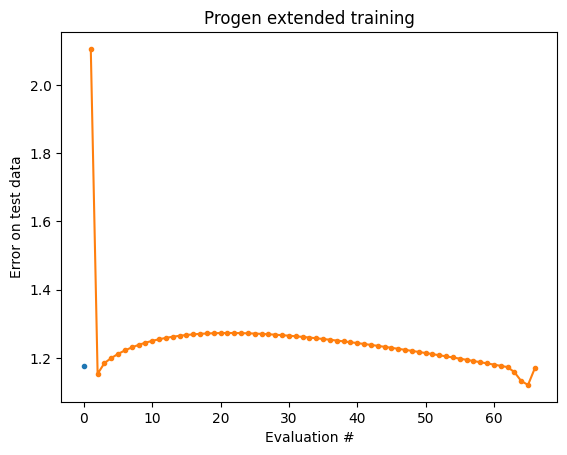

In [4]:
plt.plot(0, loss_history[0, -1], '.')
for i in range(1, loss_history.size()[0]):
    plt.plot(
        [(i-1)*loss_history.size()[1]+b for b in range(1, loss_history.size()[1]+1)],
        #torch.cat((loss_history[0, -1:], loss_history[1, :])),
        loss_history[i, :],
        ".-",
    )
plt.xlabel("Evaluation #")
plt.ylabel("Error on test data")
plt.title("Progen extended training")

plt.show()

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from progen_extended_init_test import test_initialization
from lib.utils.file import save_pt_file

s:\Documents\master\ProGen\progen\progen2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
N_INITIALIZATIONS = 100

DATA_INDEXES = [0, 1, 18, 74, 519, 623, 949, 32322, 50456, 49771]
N_DATA = None
#N_DATA = 100

LOSS_FUNCTION = torch.nn.functional.mse_loss
LOSS_FUNCTION_NAME = "mse"
RUN = 1

losses, sequences, fitnesses = test_initialization(
    n_initializations=N_INITIALIZATIONS,
    n_data=N_DATA,
    data_indexes=DATA_INDEXES,
    loss_function=LOSS_FUNCTION,
    return_data=True,
)

save_pt_file(
    {"losses": losses, "sequences": sequences, "fitnesses": fitnesses},
    #save_to=f"/data/init_test_ninit-{N_INITIALIZATIONS}_ndata-{N_DATA}_lf-{LOSS_FUNCTION_NAME}_run-{RUN}.pt",
    save_to=f"/data/init_test_ninit-{N_INITIALIZATIONS}_data-select_lf-{LOSS_FUNCTION_NAME}_run-{RUN}.pt",
    var_name="losses and data",
)

Connecting to device
Loading tokenizer
Loading GB1 data


s:\Documents\master\ProGen\progen\progen2\.venv\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Initializing model


Some weights of the model checkpoint at s:\Documents\master\code\llm\lib\model\progen/../../../../../ProGen/progen/progen2/checkpoints/progen2-small were not used when initializing ProGenModel: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing ProGenModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ProGenModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Running initialization test


s:\Documents\master\code\llm\progen_extended_init_test.py:51: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 56, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  losses[init] = loss_function(outputs, fitnesses)


Initialization 1: loss = 3.0504567623138428
Initialization 2: loss = 8.231841087341309
Initialization 3: loss = 6.611791133880615
Initialization 4: loss = 3.734952449798584
Initialization 5: loss = 7.981017112731934
Initialization 6: loss = 8.263606071472168
Initialization 7: loss = 5.743655681610107
Initialization 8: loss = 3.9771087169647217
Initialization 9: loss = 3.639610767364502
Initialization 10: loss = 8.420339584350586
Initialization 11: loss = 8.270730972290039
Initialization 12: loss = 5.089890003204346
Initialization 13: loss = 4.61594295501709
Initialization 14: loss = 8.41986083984375
Initialization 15: loss = 7.164413928985596
Initialization 16: loss = 8.370397567749023
Initialization 17: loss = 8.238313674926758
Initialization 18: loss = 7.744263172149658
Initialization 19: loss = 3.364473342895508
Initialization 20: loss = 8.223790168762207
Initialization 21: loss = 5.46920108795166
Initialization 22: loss = 10.152097702026367
Initialization 23: loss = 7.8436217308044

In [4]:
fitnesses

tensor([1.0000, 0.0619, 2.4012, 3.8915, 0.0000, 5.0753, 0.6749, 2.0556, 3.6573,
        4.0796], device='cuda:0')

In [6]:
(
    sequences,
    fitnesses,
) = get_GB1_dataset(shuffle=False, raw=True)

s:\Documents\master\ProGen\progen\progen2\.venv\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [71]:
sequence = 'AACAACAACAAACAACAACAAACAACAACAAACAACAACAAACAACAACAAACAACAACAAACAACAACAAACAACAACAAACAACAACAAACAACAACA'
#sequence = 'CCACCACCACCCACCACCACCCACCACCACCCACCACCACCCACCACCACCCACCACCACCCACCACCACCCACCACCACCCACCACCACCCACCACCAC'
sequence.count('A')

70

In [72]:
prediction = model(tokenize(sequence).to(device))

In [73]:
prediction

tensor([[ 83.6339],
        [ 83.6339],
        [ 97.4809],
        [100.6896],
        [ 88.4701],
        [ 87.8587],
        [ 85.4522],
        [ 72.6343],
        [ 84.1265],
        [ 79.6446],
        [ 58.5573],
        [ 78.8447],
        [ 92.9054],
        [ 79.2548],
        [ 79.8149],
        [ 80.9938],
        [ 80.0447],
        [ 64.2967],
        [ 79.4195],
        [ 80.0127],
        [ 64.9874],
        [ 76.4079],
        [ 86.0560],
        [ 80.3433],
        [ 62.1999],
        [ 79.2397],
        [ 80.3691],
        [ 62.5652],
        [ 79.0061],
        [ 79.3325],
        [ 62.2452],
        [ 69.8980],
        [ 84.3062],
        [ 77.7817],
        [ 61.2099],
        [ 76.6757],
        [ 79.0464],
        [ 61.9562],
        [ 76.4405],
        [ 77.5661],
        [ 62.6651],
        [ 64.0236],
        [ 82.6489],
        [ 76.2479],
        [ 59.7201],
        [ 75.7414],
        [ 77.9078],
        [ 61.8727],
        [ 75.0160],
        [ 76.1137],
